<a href="https://colab.research.google.com/github/AlexeyOm/eye-tracking/blob/main/Nemo_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load and join fixation and participant data
compiled_fixations_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/compiled_fixations.csv'
participant_info_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/participant_info.csv'

compiled_fixations_df = pd.read_csv(compiled_fixations_url)
participant_info_df = pd.read_csv(participant_info_url)

merged_df = pd.merge(compiled_fixations_df, participant_info_df, on='ID')

# replace date of birth with age
merged_df['age'] = 2023 - merged_df['DoB']
merged_df = merged_df.drop('DoB', axis=1)

# drop irrelevant columns
fix_df = merged_df[['ID', 'age', 'Order', 'duration', 'Valid', 'Valid Freeviewing']]

# convert column names to lowercase
fix_df.columns = fix_df.columns.str.lower()

fix_df.head()


,id,age,order,duration,valid,valid freeviewing
0,20230314113311129,34,0,0.350,True,True
1,20230314113311129,34,1,0.434,True,True
2,20230314113311129,34,2,0.151,True,True
3,20230314113311129,34,3,0.267,True,True
4,20230314113311129,34,4,0.232,True,True


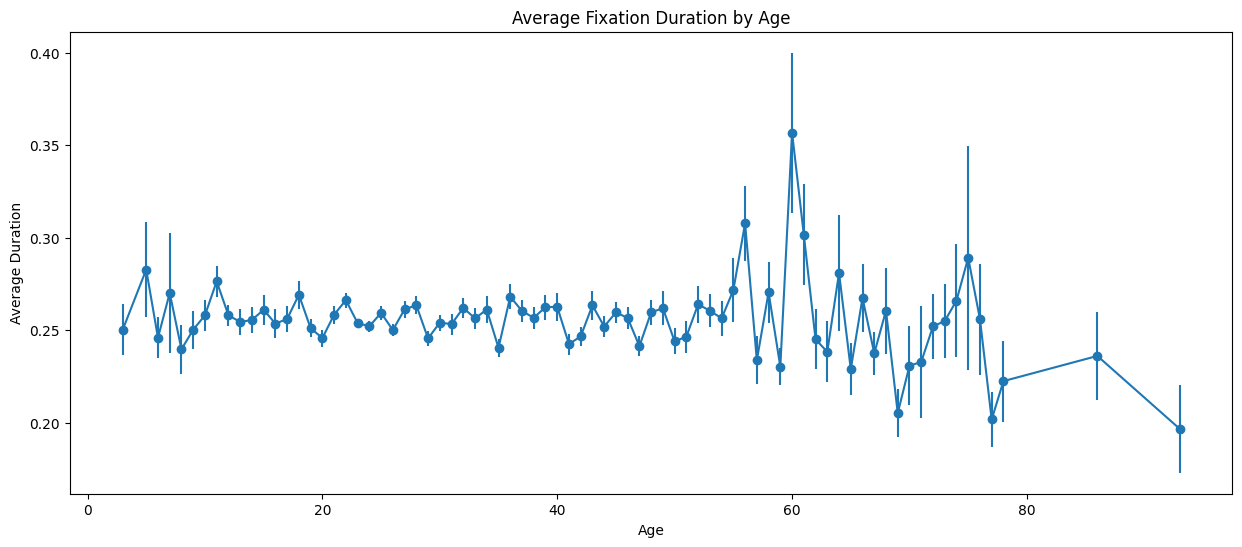

In [3]:
# Group by DoB and calculate the mean and standard error of duration
duration_stats = fix_df.groupby('age')['duration'].agg(['mean', 'sem'])

# Reset the index to make DoB a column again
duration_stats = duration_stats.reset_index()

# Create the plot
plt.figure(figsize=(15,6))
plt.errorbar(duration_stats['age'], duration_stats['mean'], yerr=duration_stats['sem'], fmt='o-')
plt.xlabel('Age')
plt.ylabel('Average Duration')
plt.title('Average Fixation Duration by Age')
plt.show()


In [4]:
# prompt: leave only Order==1 rows for each ID

# Group by 'ID' and select the row with the minimum 'Order' within each group
fix_df_order1 = fix_df.loc[fix_df.groupby('id')['order'].idxmin()]



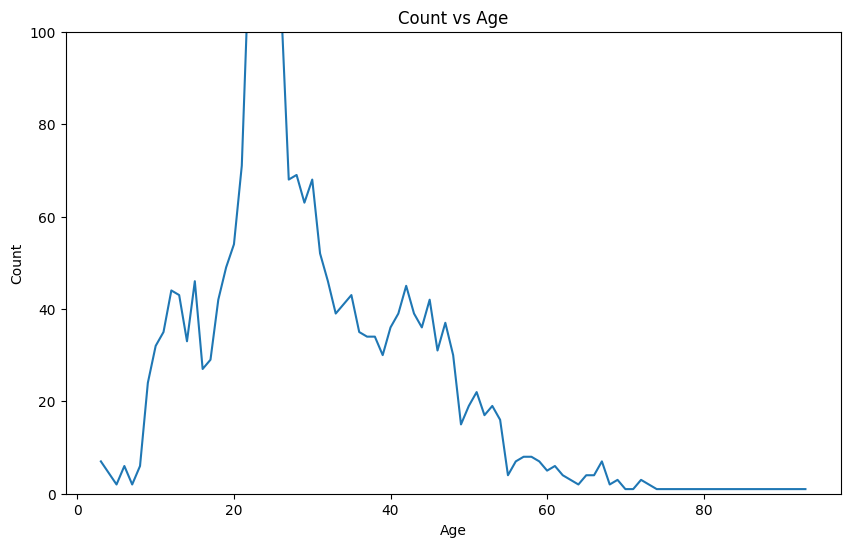

In [5]:
# prompt: Using dataframe fix_df_order1: group by age and plot the cout vs age. limit y axis of chart by 100. Use matplotlib

# Group by age and count the number of occurrences
age_counts = fix_df_order1.groupby('age')['id'].count()

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count vs Age')
plt.ylim(0, 100)  # Limit y-axis to 100
plt.show()



In [15]:
# prompt: group fix_df by id, keep mean duration and age

grouped_df = fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})
print(grouped_df)


                   duration  age
id                              
20230314113311129    0.4255   34
20230314115057038    0.2000   43
20230314115611868    0.1970   25
20230314120103643    0.2010   23
20230314120503166    0.1725   13
...                     ...  ...
20230619133520739    0.2165   33
20230619143035527    0.1835   50
20230619143908154    0.1670   43
20230619144602635    0.2085   34
20230619150017537    0.2330   22

[2724 rows x 2 columns]


In [16]:
# prompt: I have a table with mean eye fixation time in miliseconds and age as an integer, I want to fit a glm for a groupped data with age and squared age as covariate and fixation time as a response. Use python to solve this task.

import statsmodels.formula.api as sm

# Assuming your data is in a DataFrame called 'duration_stats' with columns 'age', 'mean'
grouped_df['age_squared'] = grouped_df['age'] ** 2

# Fit a GLM with age and age_squared as covariates
model = sm.glm('duration ~ age + age_squared', data=grouped_df).fit()

# Print the model summary
print(model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 2724
Model:                            GLM   Df Residuals:                     2721
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                       0.0027722
Method:                          IRLS   Log-Likelihood:                 4155.9
Date:                Fri, 11 Oct 2024   Deviance:                       7.5431
Time:                        14:21:18   Pearson chi2:                     7.54
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0001553
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2118      0.005     38.810      

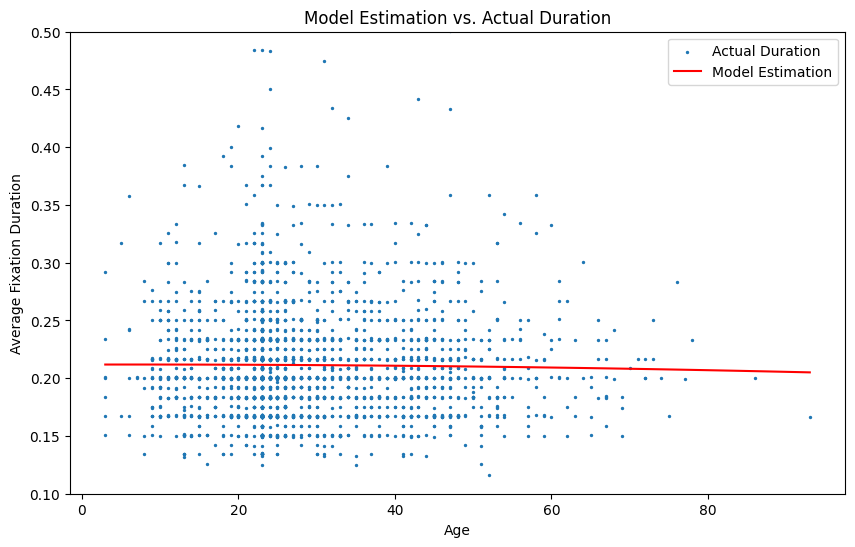

In [17]:
# prompt: plot the model estimation and actual duration vs age

import numpy as np

# Create a range of ages for plotting
age_range = np.linspace(grouped_df['age'].min(), grouped_df['age'].max(), 100)

# Predict durations for the age range using the fitted model
predicted_durations = model.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))

# Plot the actual durations and the model estimations
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['age'], grouped_df['duration'], label='Actual Duration', s=2)
plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
plt.ylim((0.1, 0.5))
plt.xlabel('Age')
plt.ylabel('Average Fixation Duration')
plt.title('Model Estimation vs. Actual Duration')
plt.legend()
plt.show()
